<a href="https://colab.research.google.com/github/Sandoval-G-98/SOA-AppJava/blob/feature%2FTP3-ejercicio-1/HPC/Cuaderno_1_grupo7_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1 Introducción
La funcionalidad pedida es: Box Blur; La misma consiste en analizar el area cicundante de un pixel denotando un cuadrado de lado x*2, siendo x el factor de blureado que se debe ingresar para el correcto funcionamiento del filtro. Teniendo el factor de blur, se analizan los pixeles circundantes al pixel a blurear y se realiza una sumatoria parcial de todos los componentes de color, para que luego, sabiendo la cantidad de pixeles circundates analizados, dividir el resultado de cada sumatoria por el total de pixeles, obteniendo asi un promedio de los pixeles circundantes. Con este promedio, se procede a settear un pixel en la misma posicion que el original pero en una nueva imagen, esto para evitar interferencias en el blureado de pixeles cercanos a pixeles ya blureados (ya que la informacion original de un pixel blureado, ya no estaria presente).

---
# 2 Armado del ambiente

In [9]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg


#@markdown ### Especifique el Blur que se desea realizar (numero entero):
#@markdown ###### Numeros mayores a 10 tardaran más de 10 minutos
blurfactor =  4#@param {type:"integer"}



--2021-11-29 05:25:16--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2021-11-29 05:25:16--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2021-11-29 05:25:16--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627577 sha256=7da174a3d5fcd4d45870586da56ccf004bfdc827bf1819deff3ba196920a8bb0
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=82c98c4325041703ef436a87451a638ecd7b4e7d16d006b41553899addcbaec4
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


---
# 3 Desarrollo CPU

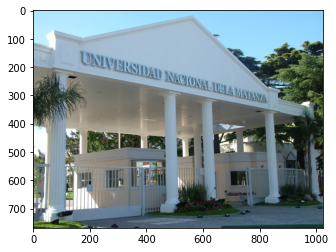

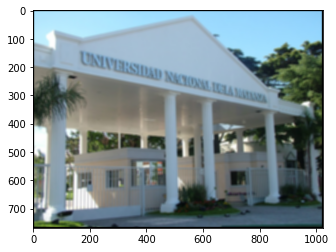

In [10]:
%matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 
from matplotlib.image import imread

global tiempo_blur_cpu, tiempo_total_cpu

def average(img, x, y, blurfactor):
  rtotal = gtotal = btotal = 0
  for x2 in range(x-blurfactor, x+blurfactor+1):
    for y2 in range(y-blurfactor, y+blurfactor+1):
      r, g, b = img.getpixel((x2, y2))
      rtotal = rtotal + r
      gtotal = gtotal + g
      btotal = btotal + b
  rtotal = rtotal // ((blurfactor * 2 + 1)**2)
  gtotal = gtotal // ((blurfactor * 2 + 1)**2)
  btotal = btotal // ((blurfactor * 2 + 1)**2)
  return (rtotal, gtotal, btotal)


# Abro la imagen
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

newImg = Image.new("RGB", (img_ancho, img_alto), (0, 0, 0))
#blurfactor = 5

tiempo_blur_cpu = datetime.now()

for x in range(blurfactor, img_ancho - blurfactor):
  for y in range(blurfactor, img_alto - blurfactor):
    r, g, b = image.getpixel((x,y))
    r2, g2, b2, = average(image, x, y, blurfactor)
    newImg.putpixel((x,y), (r2, g2, b2))

tiempo_blur_cpu = datetime.now() - tiempo_blur_cpu

plt.figure()
imgplot=plt.imshow( image )
plt.figure()
imgplot=plt.imshow( newImg )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu



---
# 4 Desarrollo GPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 16 , 19  ], Bloque : [ 64 , 41 ]
Total de Thread: [ 1024 , 779  ]  =  797696


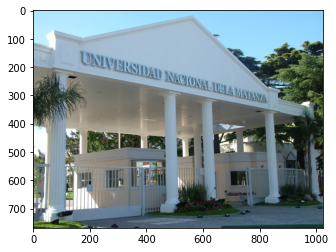

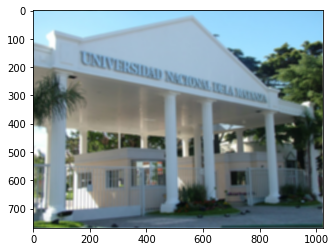

In [11]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

global tiempo_blur_gpu, tiempo_total_gpu

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like(img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int blurfactor, int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int pxl;
  //int blurfactor = 1;
  float rtotal = 0.0;
  float gtotal = 0.0;
  float btotal = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el componente de cada color para cada pixel, en base al blur ingresado.
    for (int i = idx-blurfactor; i < idx+blurfactor+1; i++)
    {
      for (int j = idy-blurfactor; j < idy+blurfactor+1; j++)
      {
        pxl = (i+(j*ancho))*3;
        rtotal += img_O[pxl  ];  // Componente Rojo  del pixel.
        gtotal += img_O[pxl+1];  // Componente Verde del pixel.
        btotal += img_O[pxl+2];  // Componente Azul  del pixel.
      }
    }

    double aux = (pow((blurfactor * 2 + 1), 2));
    pxl = (idx+(idy*ancho))*3;

    // Escribo el color del pixel.
    img_R[pxl  ] = (int) rtotal / aux;
    img_R[pxl+1] = (int) gtotal / aux;
    img_R[pxl+2] = (int) btotal / aux;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_blur_gpu = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_blur_gpu = datetime.now()

kernel( numpy.int32(blurfactor), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

tiempo_blur_gpu = datetime.now() - tiempo_blur_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

---
# 5 Métricas

In [16]:
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# --------------------------------------------
# Definición de función que transforma el tiempo en  segundos 
tiempo_en_s = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) + dt.microseconds / 1000.0

# --------------------------------------------

print( "\nCPU:")
print( "Tiempo de blur:", tiempo_en_ms( tiempo_blur_cpu  ), "[ms] --> ", tiempo_en_s(tiempo_blur_cpu),  "[s]")
print( "Tiempo total  :", tiempo_en_ms( tiempo_total_cpu ), "[ms] --> ", tiempo_en_s(tiempo_total_cpu),  "[s]" )

print( "\nGPU:")
print( "Tiempo de blur:", tiempo_en_ms( tiempo_blur_gpu  ), "[ms] --> ", tiempo_en_s(tiempo_blur_gpu),  "[s]" )
print( "Tiempo total  :", tiempo_en_ms( tiempo_total_gpu ), "[ms] --> ", tiempo_en_s(tiempo_total_gpu),  "[s]" )

print( "\nMejora de GPU vs CPU:")
print( "Mejora en tiempo de blur:", tiempo_en_ms( tiempo_blur_cpu - tiempo_blur_gpu   ), "[ms] --> ", tiempo_en_s(tiempo_blur_cpu - tiempo_blur_gpu),  "[s]" )
print( "Mejora en tiempo total  :", tiempo_en_ms( tiempo_total_cpu - tiempo_total_gpu ), "[ms] --> ", tiempo_en_s(tiempo_total_cpu - tiempo_total_gpu),  "[s]" )


CPU:
Tiempo de blur: 95323.123 [ms] -->  418.123 [s]
Tiempo total  : 95395.091 [ms] -->  490.091 [s]

GPU:
Tiempo de blur: 0.336 [ms] -->  0.336 [s]
Tiempo total  : 110.639 [ms] -->  110.639 [s]

Mejora de GPU vs CPU:
Mejora en tiempo de blur: 95322.787 [ms] -->  417.787 [s]
Mejora en tiempo total  : 95284.452 [ms] -->  379.452 [s]


---
# 6 Conclusiones

Se puede observar una clara mejora en el tiempo de ejecución en la version de GPU. La misma es de tal magnitud ya que se ejecuta el filtro de manera paralela, en contrapartida con su version en CPU, la cual es de manera secuencial. **Logrando resultados hasta 180 veces más veloces en GPU**

---
# 7 Bibliografia

[1] Markdown syntax: [url](https://www.markdownguide.org/basic-syntax/)

[2] Operadores aritméticos en Python: [url](https://www.freecodecamp.org/espanol/news/operadores-basicos-en-python-con-ejemplos/)

[3] Cuda toolkit documentation: [url](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__DEVICE.html#group__CUDART__DEVICE_1gef69dd5c6d0206c2b8d099abac61f217)

[4] Tutorial pycuda: [url](https://documen.tician.de/pycuda/tutorial.html)

[5] Idea del algoritmo para cpu: [url](https://www.youtube.com/watch?v=MbWAkCnsTy4&t=1115s)



---

---

---


# Respuesta al cuestionario:

1. Explicar detalladamente como utilizar el ejercicio (Tips: manual de usuario).
2. Deben indicar la dirección web del ejercicio dentro del repositorio GitHub.
3. Explicar cómo funciona el ejercicio desde el punto de vista de la programación CPUGPU.
4. Debe experimentar respondiendo a las consignas:

  A. ¿Qué sucede si se planifican la mitad de los hilos-gpu?
  
  B. ¿Qué sucede si se planifican el doble de hilos-gpu?
  
  C. ¿Qué cambios hay que hacer para procesar la mitad inicial de la imagen origen?
  
  D. ¿Qué cambios hay que hacer para procesar la mitad final de la imagen destino?
  
  E. ¿Cuál es el resultado si se utilizan un tamaño de bloques igual a la cantidad máxima de hilos soportada por el GPGPU?



# 1. 
Primero que nada, debes ingresar una imagen, para eso tienes que ingresar la dirección web de una imagen con  acceso público en internet en el campo "url_imagen" aqui abajo, la misma quedará disponible en el contexto de ejecuciòn del cuaderno colab.

Asimismo, debes ingresar el blurfactor deseado para el proceso de las imagenes, por defecto será 1 y la imagen resultante será similar a la original.

Luego de ingresar los datos de entrada necesarios, debes ejecutar el apartado 2.2 para que funcione correctamente la ejecucion de gpu.

Por ultimo debes ejecutar los apartados 3 y 4, no necesariamente en ese orden, seguido de el apartado 5, el cual mostrara las diferencias de tiempos en la ejecucion en mili segundos, denotando el caso de cpu y el de gpu.

# 2. 
https://github.com/Sandoval-G-98/SOA-AppJava/blob/feature/TP3-ejercicio-1/TP3/Ejercicio1/Ejecicio1_Final.ipynb

# 3. 
Como vimos en clase, la programacion del apartado 3 de CPU es secuencial, por lo que ira modificando pixel por pixel, por lo cual la ejecución se demorará bastante más que la del apartado de GPU.
Ahora bien, sobre el mencionado apartado, el mismo calcula la cantidad de bloques teniendo en cuenta la cantidad de pixeles que tiene la imagen, tanto de alto como de ancho. Por lo que analizará cada pixel en un hilo por separado, logrando un ejecucion sustancialmente más rapida. Pudiendose llegar a resultados **hasta 180 veces mas rapidos**

# 4. 

`4. A.` 
Si se planifican la mitad de hilos-gpu, manteniendo el kernel tal cual esta ahora, se procesaria solo una mitad de la imagen. Si se quisiese procesar la imagen completa, deberian realizarse ciertos cambios en el kernel para que cada hilo analice y posteriormente settee dos pixeles en lugar de solo uno, teniendo la salvedad de que no se procesen 2 o más veces algunos pixeles.

`4. B.` Al planificarse el doble de hilos, con previa verificación de que el gpu brindado por colab los soporte, habrian una mitad de hilos ociosos que pocesarian la imagen más de una vez, obteniendo el mismo resultado pero con mas fierro involucrado de manera innecesaria. 

`4. C.` Esta respuesta esta implictamente constestada en la respuesta `4. A.`

Tendria que hacer solo dos modificaciones, ya que donde comienzan los hilos se mantiene.

Entonces: 
  1. Planificar la mitad de hilos para que no hayan hilos oseosos. 
  2. Modificar la condicion de corte dentro del kernel para verificar que siempre este dentro de la mitad inicial de la imagen.

`4. D.` Tendria que hacer tres modificaciones: 
  1. Modificar el calculo de las coordenadas del Thread en dos dimensiones, que esta dentro del Kernel, para que comiencen de atras para adelante, o alguna logica cuyo resultado sea similar.
  2. Planificar la mitad de hilos para que no hayan hilos oceosos. 
  3. Modificar la condicion de corte dentro del kernel para verificar que siempre este dentro de la mitad final de la imagen.



`4. E.` Partiendo desde la base que se mantiene tal cual el Kernel, solo se conseguiría tener gran cantidad de hilos oceosos, manteniendo un resultado similar al original.